In [18]:
import xarray
from distributed import Client
import sys
sys.path.insert(1, '../heatwave_analysis_package/src')
import numpy as np
import dask
import cftime
import matplotlib.pyplot as plt


client = Client('localhost:8786')
client

<Client: 'tcp://146.6.192.149:8786' processes=10 threads=10>

In [50]:
TREFHT_DIR = "/projects/dgs/persad_research/SIMULATION_DATA/ZARR/LENS1/SIM_VARIABLES/"
HW_DIR = "/projects/dgs/persad_research/SIMULATION_DATA/ZARR/LENS1/HEAT_OUTPUTS/"

tmin_all_path = f"{TREFHT_DIR}all_day_TREFHTMN.zarr"
tmin_xaer_path = f"{TREFHT_DIR}xaer_day_TREFHTMN.zarr"
tmin_xghg_path = f"{TREFHT_DIR}xghg_day_TREFHTMN.zarr"

tmin_all_ds = xarray.open_zarr(tmin_all_path)["TREFHTMN"]
tmin_xaer_ds = xarray.open_zarr(tmin_xaer_path)["TREFHTMN"]
tmin_xghg_ds = xarray.open_zarr(tmin_xghg_path)["TREFHTMN"]

hw_mn_all_path = f"{HW_DIR}CESM1_LE_all_TREFHTMN_HW_METRICS.zarr"
hw_mn_xaer_path = f"{HW_DIR}CESM1_LE_xaer_TREFHTMN_HW_METRICS.zarr"
hw_mn_xghg_path = f"{HW_DIR}CESM1_LE_xghg_TREFHTMN_HW_METRICS.zarr"

hw_mn_all = xarray.open_zarr(hw_mn_all_path)
hw_mn_xaer = xarray.open_zarr(hw_mn_xaer_path)
hw_mn_xghg = xarray.open_zarr(hw_mn_xghg_path)

hw_mn_all_ts = hw_mn_all.sel(percentile=0.9).weighted(np.cos(np.deg2rad(hw_mn_all.lat))).mean(dim=["lat", "lon"]).compute()
hw_mn_xaer_ts = hw_mn_xaer.sel(percentile=0.9).weighted(np.cos(np.deg2rad(hw_mn_xaer.lat))).mean(dim=["lat", "lon"]).compute()
hw_mn_xghg_ts = hw_mn_xghg.sel(percentile=0.9).weighted(np.cos(np.deg2rad(hw_mn_xghg.lat))).mean(dim=["lat", "lon"]).compute()

tmin_all_ts = tmin_all_ds.resample(time="YE").mean().weighted(np.cos(np.deg2rad(tmin_all_ds.lat))).mean(dim=["lat", "lon"]).rename({"time":"year"}).compute()
tmin_xaer_ts = tmin_xaer_ds.resample(time="YE").mean().weighted(np.cos(np.deg2rad(tmin_xaer_ds.lat))).mean(dim=["lat", "lon"]).rename({"time":"year"}).compute()
tmin_xghg_ts = tmin_xghg_ds.resample(time="YE").mean().weighted(np.cos(np.deg2rad(tmin_xghg_ds.lat))).mean(dim=["lat", "lon"]).rename({"time":"year"}).compute()

tmin_all_ts = tmin_all_ts.assign_coords({"year": hw_mn_all_ts.year.values}) - 273.15
tmin_xaer_ts = tmin_xaer_ts.assign_coords({"year": hw_mn_xaer_ts.year.values}) - 273.15
tmin_xghg_ts = tmin_xghg_ts.assign_coords({"year": hw_mn_xghg_ts.year.values}) - 273.15

hw_mn_all_ts = hw_mn_all_ts.sel(year=slice(1920, 2080))
hw_mn_xaer_ts = hw_mn_xaer_ts.sel(year=slice(1920, 2080))
hw_mn_xghg_ts = hw_mn_xghg_ts.sel(year=slice(1920, 2080))

In [67]:
tmin_xghg_ds.member

<xarray.DataArray 'member' (member: 20)> Size: 240B
array(['001', '002', '003', '004', '005', '006', '007', '008', '009', '010',
       '011', '012', '013', '014', '015', '016', '017', '018', '019', '020'],
      dtype='<U3')
Coordinates:
  * member   (member) <U3 240B '001' '002' '003' '004' ... '018' '019' '020'

Text(0.5, 1.0, 'Global Ensemble Mean, Yearly Resampled TREFHTMN, LENS1')

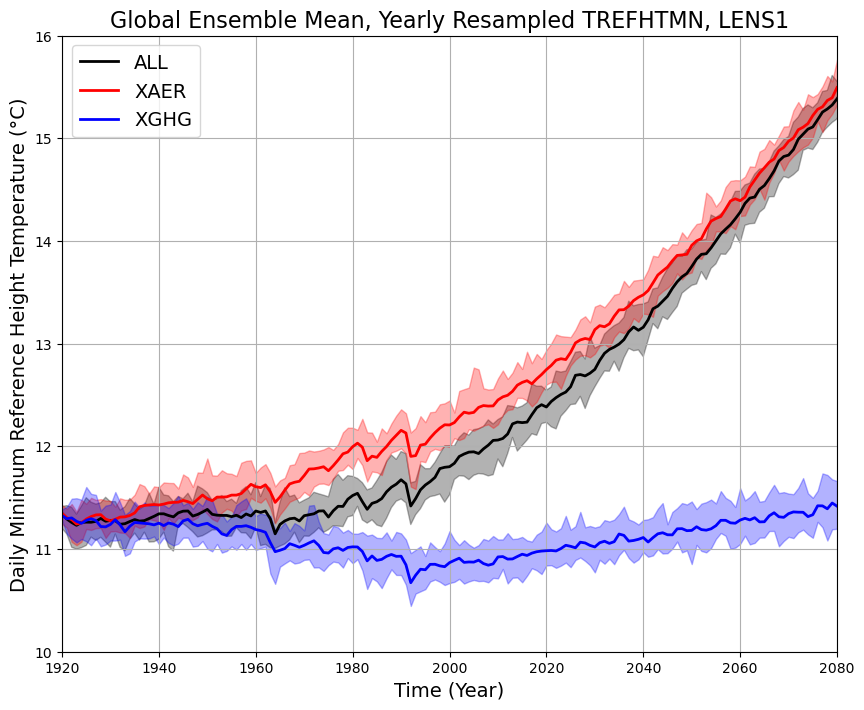

In [44]:
f, ax1 = plt.subplots(1, 1, figsize=(10, 8), facecolor='w')

lw = 2
tmin_all_ts.mean(dim="member").plot(ax=ax1, color="Black", label="ALL", linewidth=lw)
tmin_xaer_ts.mean(dim="member") .plot(ax=ax1, color="Red", label="XAER", linewidth=lw)
tmin_xghg_ts.mean(dim="member").plot(ax=ax1, color="Blue", label="XGHG", linewidth=lw)

a = 0.3
ax1.fill_between(tmin_all_ts.year.values, tmin_all_ts.min(dim="member"), tmin_all_ts.max("member"), alpha=a, color="Black")
ax1.fill_between(tmin_xaer_ts.year.values, tmin_xaer_ts.min(dim="member"), tmin_xaer_ts.max("member"), alpha=a, color="Red")
ax1.fill_between(tmin_xghg_ts.year.values, tmin_xghg_ts.min(dim="member"), tmin_xghg_ts.max("member"), alpha=a, color="Blue")

ax1.legend(fontsize=14)
ax1.grid()
ax1.set_xlim(1920, 2080)
ax1.set_ylim(10, 16)
ax1.set_xlabel("Time (Year)", fontsize=14)
ax1.set_ylabel("Daily Minimum Reference Height Temperature (°C)", fontsize=14)
ax1.set_title("Global Ensemble Mean, Yearly Resampled TREFHTMN, LENS1", fontsize=16)

In [69]:
numerator1 = (hw_mn_all_ts["HWF"] - hw_mn_xaer_ts["HWF"])
denominator1 = (tmin_all_ts - tmin_xaer_ts)
aer_per_deg = (numerator1 / denominator1).compute()

numerator2 = (hw_mn_all_ts["HWF"] - hw_mn_xghg_ts["HWF"])
denominator2 = (tmin_all_ts - tmin_xghg_ts)
ghg_per_deg = (numerator2 / denominator2).compute()

Text(0.5, 0.98, 'PROTOTYPE: LENS1, Change in Global Mean HWF per Unit Change in Global Mean TREFHTMN')

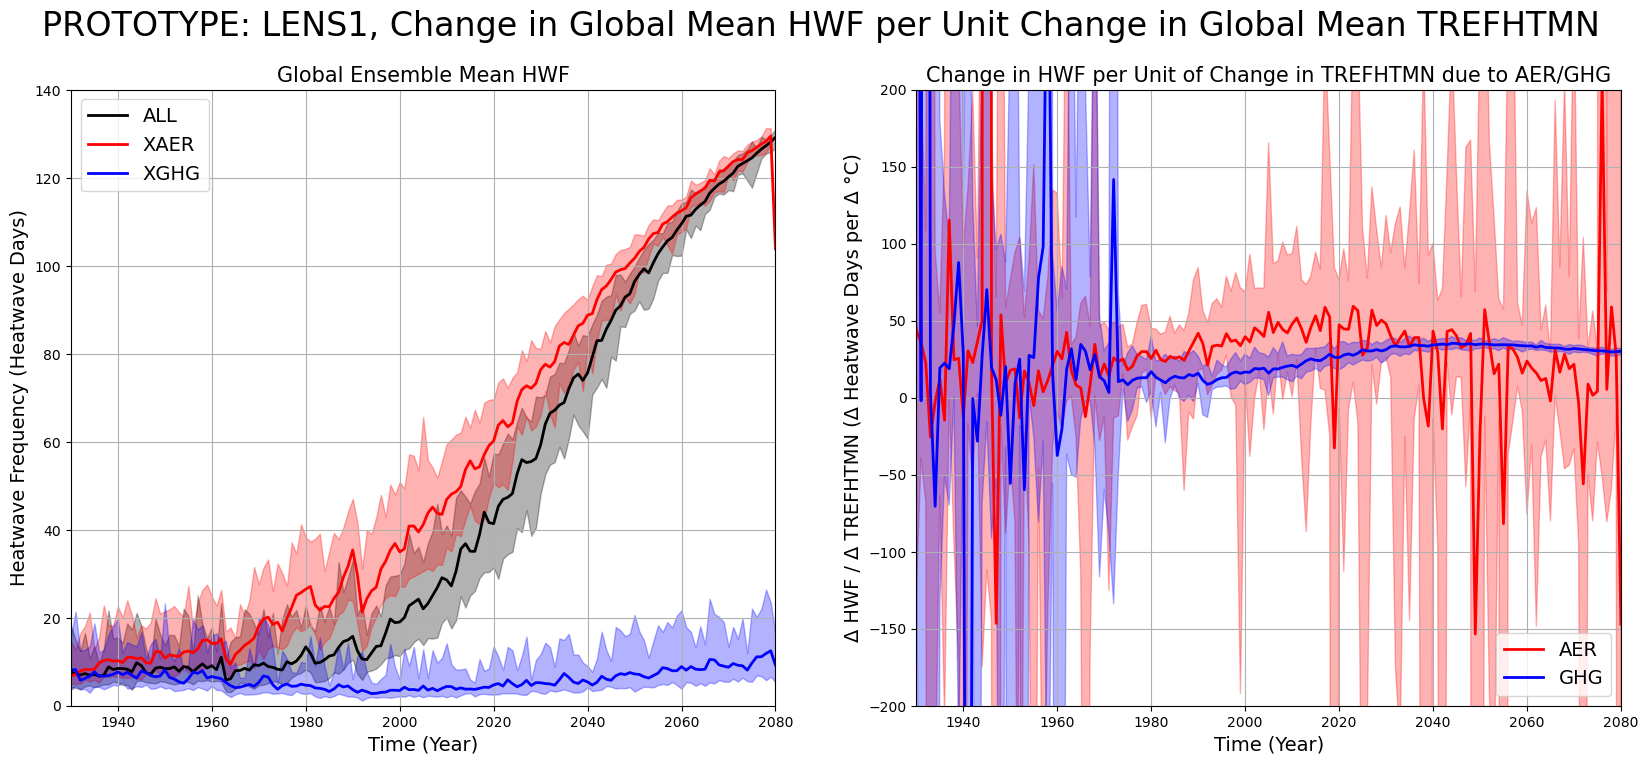

In [73]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), facecolor='w')

hw_mn_all_ts["HWF"].mean(dim="member").plot(ax=ax1, color="Black", linewidth=2, label="ALL")
hw_mn_xaer_ts["HWF"].mean(dim="member").plot(ax=ax1, color="Red", linewidth=2, label="XAER")
hw_mn_xghg_ts["HWF"].mean(dim="member").plot(ax=ax1, color="Blue", linewidth=2, label="XGHG")

a = 0.3
ax1.fill_between(hw_mn_all_ts["HWF"].year.values, hw_mn_all_ts["HWF"].min(dim="member"), hw_mn_all_ts["HWF"].max("member"), alpha=a, color="Black")
ax1.fill_between(hw_mn_xaer_ts["HWF"].year.values, hw_mn_xaer_ts["HWF"].min(dim="member"), hw_mn_xaer_ts["HWF"].max("member"), alpha=a, color="Red")
ax1.fill_between(hw_mn_xghg_ts["HWF"].year.values, hw_mn_xghg_ts["HWF"].min(dim="member"), hw_mn_xghg_ts["HWF"].max("member"), alpha=a, color="Blue")

aer_per_deg.mean(dim="member").plot(ax=ax2, color="Red", linewidth=2, label="AER")
ghg_per_deg.mean(dim="member").plot(ax=ax2, color="Blue", linewidth=2, label="GHG")

ax2.fill_between(aer_per_deg.year.values, aer_per_deg.min(dim="member"), aer_per_deg.max("member"), alpha=a, color="Red")
ax2.fill_between(ghg_per_deg.year.values, ghg_per_deg.min(dim="member"), ghg_per_deg.max("member"), alpha=a, color="Blue")

fz = 15
ax1.set_title("Global Ensemble Mean HWF", fontsize=fz)
ax2.set_title("Change in HWF per Unit of Change in TREFHTMN due to AER/GHG", fontsize=fz)

ax1.set_xlim(1930, 2080)
ax2.set_xlim(1930, 2080)

ax1.set_ylim(0, 140)
ax2.set_ylim(-200, 200)

ax1.grid()
ax2.grid()

ax1.legend(fontsize=14)
ax2.legend(fontsize=14)

fz = 14
ax1.set_ylabel("Heatwave Frequency (Heatwave Days)", fontsize=fz)
ax2.set_ylabel("Δ HWF / Δ TREFHTMN (Δ Heatwave Days per Δ °C)", fontsize=fz)

ax1.set_xlabel("Time (Year)", fontsize=fz)
ax2.set_xlabel("Time (Year)", fontsize=fz)

f.suptitle("PROTOTYPE: LENS1, Change in Global Mean HWF per Unit Change in Global Mean TREFHTMN", fontsize=24)